In [123]:
import networkx as nx
import matplotlib.pyplot as plt

class Graph:
    def __init__(self):
        self.vertices = {}
        self.steiner_vertices = []

    def add_vertex(self, vertex):
        self.vertices[vertex] = {}
        
    def add_steiner(self,vertex):
        self.steiner_vertices.append(vertex)

    def add_edge(self, vertex1, vertex2, weight):
        if vertex1 not in self.vertices:
            self.add_vertex(vertex1)
        if vertex2 not in self.vertices:
            self.add_vertex(vertex2)

        self.vertices[vertex1][vertex2] = weight
        self.vertices[vertex2][vertex1] = weight

    def get_neighbors(self, vertex):
        return self.vertices[vertex]
    
    def get_vertices(self):
        return list(self.vertices.keys())
    
    def get_steiner_vertices(self):
        return self.steiner_vertices
    
    def get_weight(self, vertex1, vertex2):
        if vertex1 in self.vertices and vertex2 in self.vertices[vertex1]:
            return self.vertices[vertex1][vertex2]
        else:
            return None
        
    def draw_graph(self):
        nx_graph = nx.Graph()
        for vertex, neighbors in self.vertices.items():
            for neighbor, weight in neighbors.items():
                nx_graph.add_edge(vertex, neighbor, weight=weight)

        ''' #Parte dello steiner Tree        
        terminals = ['A', 'E', 'F']
        # Specify the Steiner tree edges
        steiner_edges = [('A', 'D'), ('D', 'E'), ('E', 'G'),('G','C'),('C','F')]
        # Create a subgraph for the Steiner tree
        steiner_tree = nx_graph.edge_subgraph(steiner_edges)'''

        # Disegno del grafo
        pos = nx.circular_layout(nx_graph)


        # Draw the graph with terminals in red and Steiner tree edges in blue
        nx.draw_networkx(nx_graph, pos, with_labels=True, node_color='lightgray', node_size=500)
        nx.draw_networkx_labels(nx_graph, pos)
        nx.draw_networkx_nodes(nx_graph, pos, nodelist= self.steiner_vertices, node_color='#e3a5b0', node_size=500)
        edge_labels = nx.get_edge_attributes(nx_graph, 'weight')
        #nx.draw_networkx_edges(steiner_tree, pos, edge_color='blue', width=2)
        nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels = edge_labels, font_size=10)


        # Visualizzazione del grafo
        plt.axis('off')
        plt.show()
        
    def find_shortest_path(self, start_node, end_node):
        distances = {vertex: float('inf') for vertex in self.vertices}
        distances[start_node] = 0
        visited = set()
        previous = {}
        edge_weights = {}

        priority_queue = [(0, start_node)]

        while priority_queue:
            current_distance, current_node = heapq.heappop(priority_queue)

            if current_node == end_node:
                path = []
                current_edge = (end_node, previous[end_node])
                while current_node in previous:
                    path.insert(0, current_edge)
                    current_node = previous[current_node]
                    if current_node in previous:
                        current_edge = (current_node, previous[current_node])
                path.insert(0, (start_node, None))
                return path

            visited.add(current_node)

            neighbors = self.get_neighbors(current_node)
            for neighbor, weight in neighbors.items():
                if neighbor in visited:
                    continue

                new_distance = current_distance + weight
                if new_distance < distances[neighbor]:
                    distances[neighbor] = new_distance
                    previous[neighbor] = current_node
                    edge_weights[(neighbor, current_node)] = weight
                    heapq.heappush(priority_queue, (new_distance, neighbor))
        return previous, edge_weights, distances

        

In [124]:
import heapq

#Grafo di partenza su cui calcolare le distanze, nodo di partenza, nodi rispetto a cui mi interessa calcolare la distanza
def dijkstra(graph, start, steiner_tree):
    distances = {node: float('inf') for node in graph.get_vertices()}  # Initialize distances to infinity
    distances[start] = 0  # Distance from start node to itself is 0
    priority_queue = [(0, start)]  # Use a priority queue to prioritize nodes with shorter distances
    visited = set()  # Set to track visited nodes
    found_nodes = set()  # Set to track found target nodes
    
    while priority_queue and found_nodes != set(steiner_tree.get_vertices()):
        current_distance, current_node = heapq.heappop(priority_queue)  # Get the node with the smallest distance
        
        # Skip if we have already found a shorter path to the current node
        if current_distance > distances[current_node]:
            continue
        
        visited.add(current_node)  # Mark current node as visited
        
        # Check if the current node is a target node
        if current_node in steiner_tree.get_vertices():
            found_nodes.add(current_node)
        
        #Explore neighbors of the current node
        neighbors = graph.get_neighbors(current_node)
        for neighbor, weight in neighbors.items():
            if neighbor in visited:
                continue  # Skip already visited neighbors
            distance = current_distance + weight
            if distance < distances[neighbor]:  # If a shorter path is found, update the distance
                distances[neighbor] = distance
                heapq.heappush(priority_queue, (distance, neighbor))  # Add the neighbor to the priority queue
    result_distances = {}
    for i in distances:
        if i in steiner_tree.get_vertices():
            result_distances[i] = distances[i]
        
    
    return result_distances

In [125]:
def shortest_path(grafo):
    costo = 0 #NO, FALLO CON UN METODO DELLA CLASSE DEL GRAFO
    steiner_tree = Graph()
    terminals = grafo.get_steiner_vertices()
    num_terminals = len(terminals)
    
    #Estraggo il primo dei terminali e lo inserisco nel risultato
    first_node = terminals.pop(0)
    steiner_tree.add_vertex(first_node)
    steiner_tree.add_steiner(first_node)
    
    #Finchè ho dei nodi terminali da inserire nell'albero
    #while len(terminals) < num_terminals:
        #1) Trovo il nodo di steiner che ha la distanza minore dallo steiner tree attuale 
        # (Controllo Djikstra da ogni nodo terminal rispetto a tutti i nodi (dello steiner tree))
    terminals_distances = {}
    i = 0 
    #Controllo con dijkstra tutte le distanze
    for i in range(0, len(terminals)):
        print("dijkstra per: ", terminals[i])
        result_dijkstra = dijkstra(grafo, terminals[i], steiner_tree)
        print(result_dijkstra)
        #Trovo il nodo con cui il terminale ha la distanza minima
        minimum_key, minimum_distance = min(result_dijkstra.items(), key=lambda x: x[1])
        terminals_distances[terminals[i]] = {minimum_key : minimum_distance}
    print(terminals_distances)
    #Trovo quale terminale è più vicino all'albero
    minimum_value = min(terminals_distances.values(), key=lambda x: next(iter(x.values())))
    minimum_node = []
    for key, val in terminals_distances.items():
        if val == minimum_value:
            minimum_node.append(key)
    #Nodo a distanza minima, distanza dal nodo, terminals da attaccare
    nodo_di_attacco = list(minimum_value.items())[0][0]
    distanza_di_attacco = list(minimum_value.items())[0][1]
    nodo_terminal_da_aggiungere = minimum_node[0]
    
    print(nodo_di_attacco, distanza_di_attacco, nodo_terminal_da_aggiungere)

         

            
        #2) Aggiungo il nodo alla distanza e aggiorno il costo
        
    
    

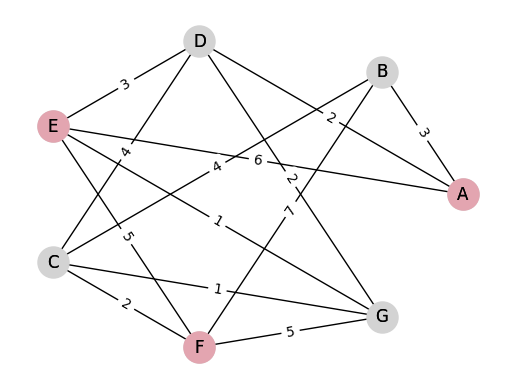

[('E', None), ('G', 'E'), ('C', 'G'), ('F', 'C')]


In [126]:
graph2 = Graph()
graph2.add_edge('A', 'B', 3)
graph2.add_edge('A', 'D', 2)
graph2.add_edge('A', 'E', 6)
graph2.add_edge('D', 'C', 4)
graph2.add_edge('D', 'E', 3)
graph2.add_edge('D', 'G', 2)
graph2.add_edge('E', 'F', 5)
graph2.add_edge('E', 'G', 1)
graph2.add_edge('G', 'F', 5)
graph2.add_edge('G', 'C', 1)
graph2.add_edge('C', 'F', 2)
graph2.add_edge('B', 'C', 4)
graph2.add_edge('F', 'B', 7)
graph2.add_steiner('A')
graph2.add_steiner('E')
graph2.add_steiner('F')


'''print("Neighbor A:", graph2.get_neighbors('A'))
print("Neighbor E:", graph2.get_neighbors('E'))
print("Neighbor F:", graph2.get_neighbors('F'))
print("Peso tra A e B: ", graph2.get_weight('A','B'))
print("Terminals: ", graph2.get_steiner_vertices())
print("Tutti i vertici: ",graph2.get_vertices())'''

graph2.draw_graph()

print(graph2.find_shortest_path('E','F'))
#steiner_tree = shortest_path(graph2)

